<a href="https://colab.research.google.com/github/preritt/CS231n-/blob/master/K_3_Hidden_2_Conv_ConvolutionalNetworksModifiedDropoutv1_10Epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%cd ..

/content


In [0]:
ls

assignment2/  assignment2ModifiedDropout.zip  sample_data/


In [0]:
!rm assignment2ModifiedDropout.zip

In [0]:
!rm -rf assignment2

In [0]:
pwd

u'/content'

In [0]:
ls

assignment2/  assignment2.zip  layers.py  sample_data/


In [0]:
import zipfile
with zipfile.ZipFile("assignment2DropoutModNoBoostK1.zip","r") as zip_ref:
    zip_ref.extractall()

In [0]:
%cd assignment2

/content/assignment2


In [0]:
%cd cs231n

/content/assignment2/cs231n


In [0]:
pwd

u'/content/assignment2/cs231n'

In [0]:
!python setup.py build_ext --inplace

running build_ext


In [0]:
%cd ..

/content/assignment2


In [0]:
pwd

u'/content/assignment2'

In [0]:
from cs231n.classifiers.cnn import *

In [0]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.cnn import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs231n.layers import *
from cs231n.fast_layers import *
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.iteritems():
  print '%s: ' % k, v.shape

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


In [0]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]]])

# Compare your output to ours; difference should be around 1e-8
print 'Testing conv_forward_naive'
print 'difference: ', rel_error(out, correct_out)

Testing conv_forward_naive
difference:  2.2121476575931688e-08


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()


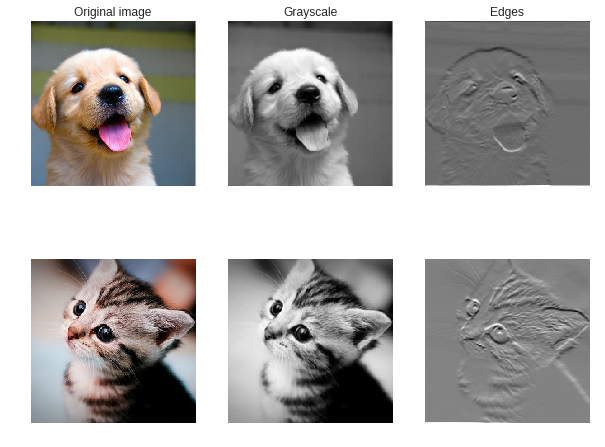

In [0]:
from scipy.misc import imread, imresize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')
# kitten is wide, and puppy is already square
d = kitten.shape[1] - kitten.shape[0]
kitten_cropped = kitten[:, d/2:-d/2, :]

img_size = 200   # Make this smaller if it runs too slow
x = np.zeros((2, 3, img_size, img_size))
x[0, :, :, :] = imresize(puppy, (img_size, img_size)).transpose((2, 0, 1))
x[1, :, :, :] = imresize(kitten_cropped, (img_size, img_size)).transpose((2, 0, 1))

# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((2, 3, 3, 3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 128])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out, _ = conv_forward_naive(x, w, b, {'stride': 1, 'pad': 1})

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# Show the original images and the results of the conv operation
plt.subplot(2, 3, 1)
imshow_noax(puppy, normalize=False)
plt.title('Original image')
plt.subplot(2, 3, 2)
imshow_noax(out[0, 0])
plt.title('Grayscale')
plt.subplot(2, 3, 3)
imshow_noax(out[0, 1])
plt.title('Edges')
plt.subplot(2, 3, 4)
imshow_noax(kitten_cropped, normalize=False)
plt.subplot(2, 3, 5)
imshow_noax(out[1, 0])
plt.subplot(2, 3, 6)
imshow_noax(out[1, 1])
plt.show()

In [0]:
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}
 
dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-9'

print 'Testing conv_backward_naive function'
print 'dx error: ', rel_error(dx, dx_num)
print 'dw error: ', rel_error(dw, dw_num)
print 'db error: ', rel_error(db, db_num)

Testing conv_backward_naive function
dx error:  8.270203451244217e-10
dw error:  1.41060442381169e-10
db error:  1.1780744080339316e-11


In [0]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

#print out
# Compare your output with ours. Difference should be around 1e-8.
print 'Testing max_pool_forward_naive function:'
print 'difference: ', rel_error(out, correct_out)

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


In [0]:
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be around 1e-12
print 'Testing max_pool_backward_naive function:'
print 'dx error: ', rel_error(dx, dx_num)

Testing max_pool_backward_naive function:
dx error:  3.2756177243137564e-12


In [0]:
from cs231n.fast_layers import conv_forward_fast, conv_backward_fast
from time import time

x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print 'Testing conv_forward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'Fast: %fs' % (t2 - t1)
print 'Speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'Difference: ', rel_error(out_naive, out_fast)

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print '\nTesting conv_backward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'Fast: %fs' % (t2 - t1)
print 'Speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'dx difference: ', rel_error(dx_naive, dx_fast)
print 'dw difference: ', rel_error(dw_naive, dw_fast)
print 'db difference: ', rel_error(db_naive, db_fast)

Testing conv_forward_fast:
Naive: 0.086142s
Fast: 0.012036s
Speedup: 7.156984x
Difference:  1.9338780430480832e-12

Testing conv_backward_fast:
Naive: 16.459155s
Fast: 0.013102s
Speedup: 1256.227008x
dx difference:  3.7249605437590395e-11
dw difference:  1.3194133784964659e-14
db difference:  0.0


In [0]:
from cs231n.fast_layers import max_pool_forward_fast, max_pool_backward_fast

x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print 'Testing pool_forward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'fast: %fs' % (t2 - t1)
print 'speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'difference: ', rel_error(out_naive, out_fast)

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print '\nTesting pool_backward_fast:'
print 'Naive: %fs' % (t1 - t0)
print 'speedup: %fx' % ((t1 - t0) / (t2 - t1))
print 'dx difference: ', rel_error(dx_naive, dx_fast)

Testing pool_forward_fast:
Naive: 0.283335s
fast: 0.002412s
speedup: 117.464960x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.638012s
speedup: 40.890181x
dx difference:  0.0


In [0]:
from cs231n.layer_utils import conv_relu_pool_forward, conv_relu_pool_backward

x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

print 'Testing conv_relu_pool'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing conv_relu_pool
dx error:  1.781084259748896e-08
dw error:  1.2351267316664651e-09
db error:  1.9370894517917888e-10


In [0]:
from cs231n.layer_utils import conv_relu_forward, conv_relu_backward

x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

print 'Testing conv_relu:'
print 'dx error: ', rel_error(dx_num, dx)
print 'dw error: ', rel_error(dw_num, dw)
print 'db error: ', rel_error(db_num, db)

Testing conv_relu:
dx error:  5.12466601721978e-09
dw error:  8.378504191006119e-10
db error:  7.747948962587533e-12


In [0]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print 'Initial loss (no regularization): ', loss

model.reg = 0.5
loss, grads = model.loss(X, y)
print 'Initial loss (with regularization): ', loss

Initial loss (no regularization):  2.3025847603331284
Initial loss (with regularization):  2.5084688891421036


In [0]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 1.171526e-01
W2 max relative error: 5.542209e-03
W3 max relative error: 5.957221e-06
b1 max relative error: 2.419495e-04
b2 max relative error: 1.008179e-06
b3 max relative error: 1.143522e-09


In [0]:
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 40) loss: 2.362427
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.133000
(Iteration 2 / 40) loss: 3.989005
(Epoch 1 / 20) train acc: 0.170000; val_acc: 0.119000
(Iteration 3 / 40) loss: 3.799296
(Iteration 4 / 40) loss: 2.269374
(Epoch 2 / 20) train acc: 0.290000; val_acc: 0.169000
(Iteration 5 / 40) loss: 3.001829
(Iteration 6 / 40) loss: 2.312756
(Epoch 3 / 20) train acc: 0.370000; val_acc: 0.126000
(Iteration 7 / 40) loss: 2.198249
(Iteration 8 / 40) loss: 2.309321
(Epoch 4 / 20) train acc: 0.330000; val_acc: 0.127000
(Iteration 9 / 40) loss: 2.023736
(Iteration 10 / 40) loss: 1.923291
(Epoch 5 / 20) train acc: 0.480000; val_acc: 0.175000
(Iteration 11 / 40) loss: 1.755005
(Iteration 12 / 40) loss: 1.519614
(Epoch 6 / 20) train acc: 0.530000; val_acc: 0.204000
(Iteration 13 / 40) loss: 1.576888
(Iteration 14 / 40) loss: 1.541050
(Epoch 7 / 20) train acc: 0.670000; val_acc: 0.229000
(Iteration 15 / 40) loss: 1.380113
(Iteration 16 / 40) loss: 1.028907
(Epoch 8 / 20) tr

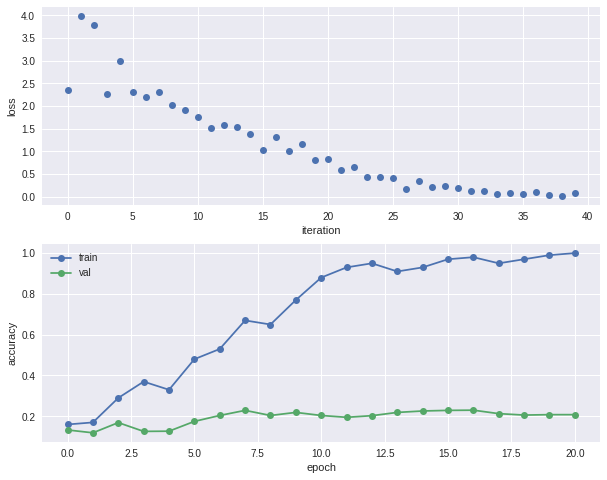

In [0]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [0]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 980) loss: 2.304641
(Epoch 0 / 1) train acc: 0.136000; val_acc: 0.136000
(Iteration 21 / 980) loss: 2.083599
(Iteration 41 / 980) loss: 2.027519
(Iteration 61 / 980) loss: 1.980401
(Iteration 81 / 980) loss: 1.806757
(Iteration 101 / 980) loss: 1.741621
(Iteration 121 / 980) loss: 1.826143
(Iteration 141 / 980) loss: 1.871321
(Iteration 161 / 980) loss: 1.614698
(Iteration 181 / 980) loss: 1.953457


KeyboardInterrupt: ignored

In [0]:
model = MultiLayerConvNet(weight_scale=0.001, hidden_dim=[800,400,200], reg=0.001, dropout = 0.5)

solver = Solver(model, data,
                num_epochs=5, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

IndexError: ignored

In [0]:
from cs231n.classifiers.cnn import *

In [0]:
model = MultiLayerConvNet(weight_scale=0.001, hidden_dim=[800,400,200], reg=0.001, dropout = 0.5)

solver = Solver(model, data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

(Iteration 1 / 9800) loss: 2.303919
(Epoch 0 / 10) train acc: 0.101000; val_acc: 0.091000
(Iteration 21 / 9800) loss: 2.037236
(Iteration 41 / 9800) loss: 1.967300
(Iteration 61 / 9800) loss: 1.872776
(Iteration 81 / 9800) loss: 1.879559
(Iteration 101 / 9800) loss: 1.846245
(Iteration 121 / 9800) loss: 2.021563
(Iteration 141 / 9800) loss: 1.653549
(Iteration 161 / 9800) loss: 1.754207
(Iteration 181 / 9800) loss: 1.741509
(Iteration 201 / 9800) loss: 1.674799
(Iteration 221 / 9800) loss: 1.625490
(Iteration 241 / 9800) loss: 1.684701
(Iteration 261 / 9800) loss: 1.655801
(Iteration 281 / 9800) loss: 1.545522
(Iteration 301 / 9800) loss: 1.363186
(Iteration 321 / 9800) loss: 1.854974
(Iteration 341 / 9800) loss: 1.444639
(Iteration 361 / 9800) loss: 1.432451
(Iteration 381 / 9800) loss: 1.525667
(Iteration 401 / 9800) loss: 1.462732
(Iteration 421 / 9800) loss: 1.582167
(Iteration 441 / 9800) loss: 1.472011
(Iteration 461 / 9800) loss: 1.409040
(Iteration 481 / 9800) loss: 1.381508
(I

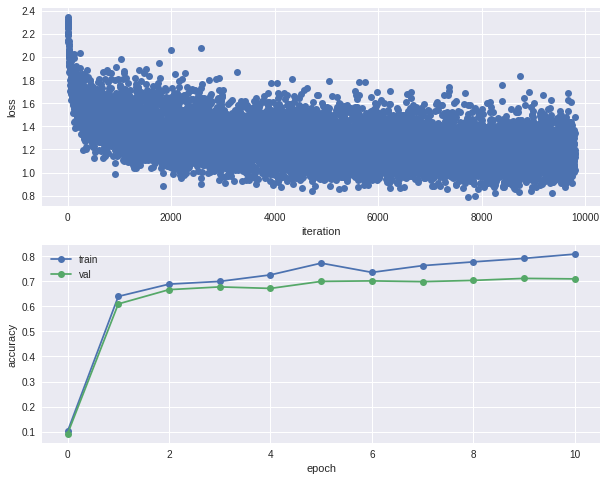

In [0]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

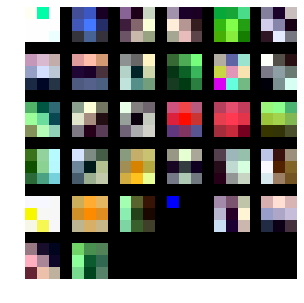

In [0]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

In [0]:
solver.check_accuracy(data['X_test'], data['y_test'])

0.69

def dropout_forward(x, dropout_param):
  """
  Performs the forward pass for (inverted) dropout.

  Inputs:
  - x: Input data, of any shape
  - dropout_param: A dictionary with the following keys:
    - p: Dropout parameter. We drop each neuron output with probability p.
    - mode: 'test' or 'train'. If the mode is train, then perform dropout;
      if the mode is test, then just return the input.
    - seed: Seed for the random number generator. Passing seed makes this
      function deterministic, which is needed for gradient checking but not in
      real networks.

  Outputs:
  - out: Array of the same shape as x.
  - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
    mask that was used to multiply the input; in test mode, mask is None.
  """
  p, mode = dropout_param['p'], dropout_param['mode']
  if 'seed' in dropout_param:
    np.random.seed(dropout_param['seed'])

  mask = None
  out = None

  if mode == 'train':
    ###########################################################################
    # TODO: Implement the training phase forward pass for inverted dropout.   #
    # Store the dropout mask in the mask variable.                            #
    ###########################################################################
    #pass
    #mask = (np.random.rand((x.shape[0],x.shape[1]))<p)/p
    #print type(x.shape)
    
    mask = (np.random.random_sample(x.shape)<p)/p
    out = x
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################
  elif mode == 'test':
    ###########################################################################
    # TODO: Implement the test phase forward pass for inverted dropout.       #
    ###########################################################################
    #pass
    mask = np.ones((x.shape))
    out = x
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################

  cache = (dropout_param, mask)
  out = out.astype(x.dtype, copy=False)

  return out, cache


def dropout_backward(dout, cache):
  """
  Perform the backward pass for (inverted) dropout.

  Inputs:
  - dout: Upstream derivatives, of any shape
  - cache: (dropout_param, mask) from dropout_forward.
  """
  dropout_param, mask = cache
  mode = dropout_param['mode']
  
  dx = None
  if mode == 'train':
    ###########################################################################
    # TODO: Implement the training phase backward pass for inverted dropout.  #
    ###########################################################################
    #pass
    p = dropout_param['p']
    dx = dout*mask
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################
  elif mode == 'test':
    dx = dout
  return dx


In [0]:
# # # # # # # def dropout_forward(x, dropout_param):
# # # # # # #   """
# # # # # # #   Performs the forward pass for (inverted) dropout.

# # # # # # #   Inputs:
# # # # # # #   - x: Input data, of any shape
# # # # # # #   - dropout_param: A dictionary with the following keys:
# # # # # # #     - p: Dropout parameter. We drop each neuron output with probability p.
# # # # # # #     - mode: 'test' or 'train'. If the mode is train, then perform dropout;
# # # # # # #       if the mode is test, then just return the input.
# # # # # # #     - seed: Seed for the random number generator. Passing seed makes this
# # # # # # #       function deterministic, which is needed for gradient checking but not in
# # # # # # #       real networks.

# # # # # # #   Outputs:
# # # # # # #   - out: Array of the same shape as x.
# # # # # # #   - cache: A tuple (dropout_param, mask). In training mode, mask is the dropout
# # # # # # #     mask that was used to multiply the input; in test mode, mask is None.
# # # # # # #   """
# # # # # # #   p, mode = dropout_param['p'], dropout_param['mode']
# # # # # # #   if 'seed' in dropout_param:
# # # # # # #     np.random.seed(dropout_param['seed'])

# # # # # # #   mask = None
# # # # # # #   out = None

# # # # # # #   if mode == 'train':
# # # # # # #     ###########################################################################
# # # # # # #     # TODO: Implement the training phase forward pass for inverted dropout.   #
# # # # # # #     # Store the dropout mask in the mask variable.                            #
# # # # # # #     ###########################################################################
# # # # # # #     #pass
# # # # # # #     #mask = (np.random.rand((x.shape[0],x.shape[1]))<p)/p
# # # # # # #     #print type(x.shape)
    
# # # # # # #     mask = (np.random.random_sample(x.shape)<p)/p
# # # # # # #     out = x
# # # # # # #     ###########################################################################
# # # # # # #     #                            END OF YOUR CODE                             #
# # # # # # #     ###########################################################################
# # # # # # #   elif mode == 'test':
# # # # # # #     ###########################################################################
# # # # # # #     # TODO: Implement the test phase forward pass for inverted dropout.       #
# # # # # # #     ###########################################################################
# # # # # # #     #pass
# # # # # # #     mask = np.ones((x.shape))
# # # # # # #     out = x
# # # # # # #     ###########################################################################
# # # # # # #     #                            END OF YOUR CODE                             #
# # # # # # #     ###########################################################################

# # # # # # #   cache = (dropout_param, mask)
# # # # # # #   out = out.astype(x.dtype, copy=False)

# # # # # # #   return out, cache


# # # # # # # def dropout_backward(dout, cache):
# # # # # # #   """
# # # # # # #   Perform the backward pass for (inverted) dropout.

# # # # # # #   Inputs:
# # # # # # #   - dout: Upstream derivatives, of any shape
# # # # # # #   - cache: (dropout_param, mask) from dropout_forward.
# # # # # # #   """
# # # # # # #   dropout_param, mask = cache
# # # # # # #   mode = dropout_param['mode']
  
# # # # # # #   dx = None
# # # # # # #   if mode == 'train':
# # # # # # #     ###########################################################################
# # # # # # #     # TODO: Implement the training phase backward pass for inverted dropout.  #
# # # # # # #     ###########################################################################
# # # # # # #     #pass
# # # # # # #     p = dropout_param['p']
# # # # # # #     dx = dout*mask
# # # # # # #     ###########################################################################
# # # # # # #     #                            END OF YOUR CODE                             #
# # # # # # #     ###########################################################################
# # # # # # #   elif mode == 'test':
# # # # # # #     dx = dout
# # # # # # #   return dx
